# Intro

### Goal

### Libraries and modules

### Hyperparameters

The model hyperparameters to tune are:
* Image (square) dimensions (50, 100, 200, 300)
* Number of convolutional layers (1, 2, 3)
* Kernel size (5, 6, 7)
* Stride (1, 2, kernel size)

The training hyperparameters we will tune are:
* Number of training epochs (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
* Learning rate (0.1, 0.01, 0.001)
* Training sample size (100, 1000, 10000, 20000)
* Batch size (16, 32, 64)

# Environment setup

We start by importing the libraries and modules needed for this analysis.

In [1]:
# For reading, handling data and calculations
import os
import pandas as pd
import numpy as np
from collections import defaultdict

# For displaying images, plotting metrics, etc.
from matplotlib import pyplot as plt
import seaborn as sns

# For splitting samples into training and testing
from sklearn.model_selection import train_test_split

# PyTorch modules for building, training, and evaluating neural networks
import torch
from torch import Generator
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Sampler, WeightedRandomSampler

# Torchvision modules for computer vison and image handling
import torchvision
from torchvision import datasets
from torchvision.transforms import v2

# Metrics for evaluating model performance
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix

# For displaying commands in each cell
from IPython.core.interactiveshell import InteractiveShell

# tqdm allows us to display a progress bar for long loops
from tqdm import tqdm 

Initialize some settings for displaying, plotting, etc. Also set the device on which to train the model (CPU, or GPU if availible)

In [2]:
# Display output of every command in a cell
InteractiveShell.ast_node_interactivity = 'all'

# Progress bar for pandas
tqdm.pandas()

# Set seaborn style and color palette
sns.set_style('darkgrid')
my_palette = ['#D62828','#003049','#F77F00','#FCBF49','#EAE2B7','#6E9075','#EFBDEB','#1B998B','#F0F757','#777DA7']
sns.set_palette(my_palette, n_colors=10)

# Set random generator seeds for reproducibility 
SEED_1 = 24
SEED_2 = 48
torch.manual_seed(SEED_1);

In [3]:
# Device on which to train model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Define input/output folder paths and create subfolders to store output files like figures, intermediate data, and trained models

In [4]:
# Root path to all images
RAW_DATA_PATH = '/kaggle/input/animals10/raw-img/'

# Path for all outputs
OUT_PATH = '/kaggle/working/'

# Folders and subfolders for data, figures, and models
DATA_PATH = os.path.join(OUT_PATH, 'data')
INTERIM_DATA_PATH = os.path.join(DATA_PATH, 'interim')
FIGURE_PATH = os.path.join(OUT_PATH, 'figures')
MODEL_PATH = os.path.join(OUT_PATH, 'models')

if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
if not os.path.exists(INTERIM_DATA_PATH):
    os.mkdir(INTERIM_DATA_PATH)
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# Read and Split the Data

We can now begin reading and processing the data we explored in module 1.

Since the raw image data are separated into folders by class, we can create a data loader with the `ImageFolder` class from `torchvision`, which is designed for this exact file structure. Then each time we iterate on the loader it will read an image and its label without having to store all the images in memory at once.

The `RandAugment` class from `torchvision` allows us to apply N random augmentations, sequentially, to each image. Augmenting the data will reduce overfitting the model when oversampling.

In [5]:
IMAGE_SIZE = 300
NUM_AUGS = 4
AUG_MAG = 9

# Define transforms for resizing and augmentation
my_transforms = v2.Compose([v2.ToImage(),
                            v2.ToDtype(torch.uint8, scale=True),
                            v2.Pad(IMAGE_SIZE),
                            v2.CenterCrop(IMAGE_SIZE),
                            v2.RandAugment(num_ops=NUM_AUGS, magnitude=AUG_MAG),
                            v2.ToDtype(torch.float32, scale=True)
                           ])

# Create dataset, supply transforms to loader
dataset = datasets.ImageFolder(root=RAW_DATA_PATH, transform=my_transforms)

dataset.class_to_idx

# Since animal names are in italian we will have to translate into English
translate = {'cane': 'Dog', 
             'cavallo': 'Horse', 
             'elefante': 'Elephant', 
             'farfalla': 'Butterfly', 
             'gallina': 'Chicken', 
             'gatto': 'Cat', 
             'mucca': 'Cow', 
             'pecora': 'Sheep', 
             'ragno': 'Spider', 
             'scoiattolo': 'Squirrel'
            }

# Get mapping from class index to English label for plotting
idx_to_label = {idx: translate[class_ita] for class_ita, idx in dataset.class_to_idx.items()}

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

Quickly validate that the images are loaded properly and the image augmentation is appropriate.

In [6]:
# Create dataloader to randomly sample images
tmp_loader = DataLoader(dataset, shuffle=True, generator=Generator('cpu').manual_seed(SEED_1))

# Create figure with 4 x 4 subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16))

# Plot first 16 in random sample
for row in range(4):
    for col in range(4):
        
        # Grab the image tensor and label (class index)
        features, labels = next(iter(tmp_loader))
        
        # Tensors are of dimension (channel, width, height) but to plot we want (width, height, channel), so permute the dimensions
        ax[row, col].imshow(features[0].permute(1, 2, 0))
        
        # Clean up images
        ax[row, col].grid(False)
        ax[row, col].set_xlabel(idx_to_label[labels[0].item()], size=14)
        
# Save the figure
plt.savefig(os.path.join(FIGURE_PATH,'augmented-image-sample.pdf'), bbox_inches='tight');

Split the data into training and testing sets with an 80/20 split. To ensure that the class distribution of the testing set is representative of the training set, we use stratified sampling and return the lists of indicies from the original dataset that belong to the new training/testing sets.

In [7]:
TRAIN_SPLIT = 0.8

# Split the dataset into training and testing subsets; return indices of subsets
train_idx, test_idx = train_test_split(np.arange(len(dataset.targets)), 
                                       train_size=TRAIN_SPLIT,  
                                       random_state=SEED_1, 
                                       shuffle=True, 
                                       stratify=dataset.targets
                                      )

# Data Sampling

As we observed when exploring the dataset in module 1, there is a large imbalance in the classes. This will bias the model we train and will likely lead to a model that always predicts dogs or spiders, as these two classes account for almost half the images. To overcome this, we will *oversample* the minority classes when training such that there is a balanced representation of each class. This requires that some images in the minority classes will pass through the model more than once during training, which can lead to overfitting, but by augmenting the images (e.g., flipping or rotating an image) we can introduce variability into the model and reduce any overfitting. We will have to build a custom sampler and dataloader to handle all of this.

In [8]:
# Functions we need to produced class-balanced samples of our dataset

def balanced_class_weights(targets, subset_idx):
    '''Return the per-class weights needed to balance the class distributions.
    
    Each class's weight is defined as the reciprical of the class's count in the subset.
    When data are sampled from each subset with these weights, the class distribution will
    be approximately balanced for a sufficiently large sample.
    '''
    subset_idx = set(subset_idx)
    class_counts = defaultdict(int)
    for idx, target in enumerate(targets):
        if idx in subset_idx:
            class_counts[target] += 1
            
    weights = [1./count for _, count in sorted(class_counts.items())]
    return weights

def balanced_sample_weights(targets, subset_idx):
    '''Return the per-sample weights needed to balance the class distributions.
    
    Every element in the dataset will be assigned its corresponding class weight for the subset.
    Elements in the dataset outside of the subset will be assigned a weight of zero, 
    so those elements will not be sampled when the weights are passed to a sampler.
    '''
    
    # Get the weights for each class
    weights = balanced_class_weights(targets, subset_idx)
    
    # Assign the corresponding class weight to each target index in the subset 
    # and a weight of zero to target indices outside of the subset
    subset_idx = set(subset_idx)
    sample_weights = [0]*len(targets)
    for idx, target in enumerate(targets):
        if idx in subset_idx:
            sample_weights[idx] = weights[target]
            
    return sample_weights

def balanced_sampler(targets, subset_idx, num_samples, generator):
    '''Returns a random sampler weighted to balance the classes within the subset.'''
    
    # We will sample images based on the inverse of their class frequency in the subset to balance the representation of each class
    weights = balanced_sample_weights(targets, subset_idx)
    
    # The sampler will tell the dataloader to randomly sample images according to the weights we defined;
    # Images in the minority classes will be sampled more frequently than from majority classes
    sampler = WeightedRandomSampler(weights, 
                                    num_samples=num_samples,
                                    replacement=True, 
                                    generator=generator
                                   )
    return sampler

Let's validate that the samplers are producing balanced subsets.

In [9]:
BATCH_SIZE = 16

# Samplers to oversample the train or test set such that the classes are balanced
tmp_train_sampler = balanced_sampler(dataset.targets,
                                     subset_idx=train_idx,
                                     num_samples=1600,
                                     generator=Generator('cpu').manual_seed(SEED_1)
                                    )

tmp_test_sampler = balanced_sampler(dataset.targets,
                                    subset_idx=test_idx,
                                    num_samples=1600,
                                    generator=Generator('cpu').manual_seed(SEED_2)
                                   )

# Dataloaders to randomly sample each train/test dataset in batches
tmp_train_loader = DataLoader(dataset, sampler=tmp_train_sampler, batch_size=BATCH_SIZE, num_workers=4)
tmp_test_loader = DataLoader(dataset, sampler=tmp_test_sampler, batch_size=BATCH_SIZE, num_workers=4)

# Get the class label for each target and load into pandas dataframe for analysis/plotting
tmp_train_counts = np.array([label for label in [labels.tolist() for _, labels in tqdm(tmp_train_loader)]]).flatten()
tmp_test_counts = np.array([label for label in [labels.tolist() for _, labels in tqdm(tmp_test_loader)]]).flatten()

df_train = pd.DataFrame({'class_idx': tmp_train_counts})
df_test = pd.DataFrame({'class_idx': tmp_test_counts})

df_train['label'] = df_train['class_idx'].apply(lambda x: idx_to_label[x])
df_test['label'] = df_test['class_idx'].apply(lambda x: idx_to_label[x])

df_train_counts = df_train['label'].value_counts()
df_test_counts = df_test['label'].value_counts()

# Inspect the dataframes
df_train_counts
df_test_counts

100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


label
Cow          174
Chicken      168
Elephant     166
Sheep        166
Spider       163
Squirrel     160
Horse        157
Butterfly    157
Dog          150
Cat          139
Name: count, dtype: int64

label
Cow          181
Elephant     174
Cat          167
Chicken      167
Squirrel     165
Sheep        164
Horse        164
Spider       154
Dog          133
Butterfly    131
Name: count, dtype: int64

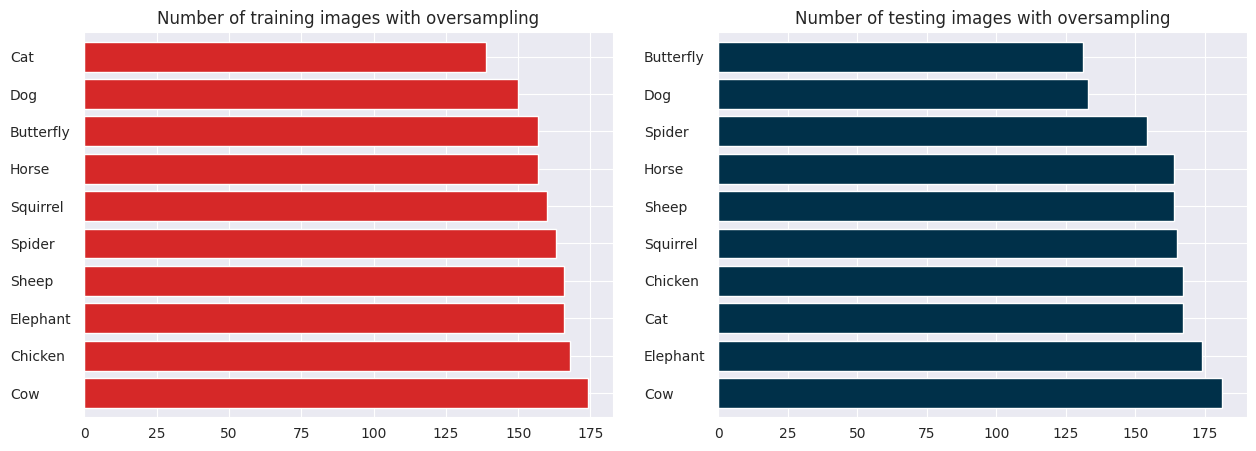

In [10]:
# Create fig and subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

df_train_counts.plot(kind='barh', title='Number of training images with oversampling', width=.8, color=my_palette[0], ax=ax[0])
df_test_counts.plot(kind='barh', title='Number of testing images with oversampling', width=.8, color=my_palette[1], ax=ax[1])

# Clean up y-axis labels
ax[0].set(ylabel=None)
ax[1].set(ylabel=None)

ax[0].tick_params(axis='y', pad=50)  
ax[1].tick_params(axis='y', pad=50)  

ax[0].set_yticklabels(ax[0].get_yticklabels(), ha='left')
ax[1].set_yticklabels(ax[1].get_yticklabels(), ha='left')

# Save figure
plt.savefig(os.path.join(FIGURE_PATH,'validate-balanced-classes.pdf'), bbox_inches='tight');

As we can see from the bar charts of the training and testing samples, the classes are much more balanced than before by oversampling the minority classes. This will reduce the class bias when training our model. 

Now create data loaders with a larger sample size for the actual analysis.

In [11]:
# Samplers to oversample minority classes such that all classes are balanced
train_sampler = balanced_sampler(dataset.targets,
                                 subset_idx=train_idx,
                                 num_samples=len(train_idx),
                                 generator=Generator('cpu').manual_seed(SEED_1)
                                )

test_sampler = balanced_sampler(dataset.targets,
                                subset_idx=test_idx,
                                num_samples=len(test_idx),
                                generator=Generator('cpu').manual_seed(SEED_2)
                               )

# Dataloaders to randomly sample each train/test dataset in batches
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

# Building the Neural Network

Now we will build the model and specify the hyperparameters. 

The model we will use is a Convolutional Neural Network (CNN). Our model will subclass `Module` from the `torch` library and consist of:

* One convolution layer with a 5 x 5 kernel, 6 features, and a stride of 1
* One 2 x 2 max pooling layer with a stride of 2
* A second convolution layer with a 5 x 5 kernel, 16 features, and a stride of 1
* A second 2 x 2 pooling layer with a stride of 2
* Three fully-connected layers reducing the dimensions from 82944 -> 120 -> 84 -> 10
* All convolution and fully-connected layer logits are passed through the ReLu activation function
* The final 1 x 10 dimensional output layer is passed through the softmax function to return probabilities

In [17]:
# Now build the image classifier with a Convolutional Neural Network (CNN)

class ImageClassifier(nn.Module):
    '''Convolutional Neural Network for classifying images into 1 of 10 classes.'''
    
    def __init__(self):
        '''Initialize the CNN and define the layers.'''
        super().__init__()
        
        # Input -> 3 x 300 x 300 (RBG channels, pixel height, pixel width)
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # Conv1 -> 6 x 296 x 296 : where ((300 - 5)/1) + 1 = 296
        self.pool = nn.MaxPool2d(2, 2)
        # Pool1 -> 6 x 148 x 148 : where ((296 - 2)/2) + 1 = 148
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Conv2 -> 16 x 144 x 144 : where ((144 - 5)/1) + 1 = 144
        # Pool2 -> 16 x 72 x 72 : where ((144 - 2)/2) + 1 = 72
        # flatten -> 82944 : where 16 * 72 * 72 = 82944
        # Fully-connected layers
        self.fc1 = nn.Linear(16 * 72 * 72, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        '''Forward propogation of image through model.'''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1) # flatten dimensions (start_dim=1 to keep batches)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #F.softmax(self.fc3(x), dim=1) 
        return x


my_model = ImageClassifier().to(device)
my_model

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

We will start by training 10 epochs with a learning rate of 0.001 and momentum of 0.9.

# Training the Neural Network

In [18]:
# Set the training hyperparameters
EPOCHS = 10 # number of gradient descent passes in the model fitting
LEARNING_RATE = 0.01 # size of each step in gradient descent procedure
MOMENTUM = 0.9 # Momentum, speeds up training

Now we will decide how the model will be trained. We need to select a loss function: the metric by which to measure if the model has improved or worsened after adjusting the weights and biases. We also need to select an optimizer: a `torch` object that will store the model state, compute and the gradients (backpropgation) and updates the model weights.

For the loss function we will use `CrossEntropyLoss` which is a function used when building a classifier.

For the optimizer we will use `StochasticGradientDescent` that will perform stochastic gradient descent when computing the gradients.

In [19]:
ce_loss = nn.CrossEntropyLoss()
sgd_opt = optim.SGD(my_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

mca_metric = MulticlassAccuracy(num_classes=10).to(device)
mccm_metric = MulticlassConfusionMatrix(num_classes=10).to(device)

Let's define a function that will train a model over one epoch by looping through each mini-batch. 

A rough brakdown of each loop is:
* Grab the current mini-batch of inputs/targets
* Encode the class indices of the targets to one-hot vectors
* Set the gradients in the model to zero
* Pass the inputs to the model and get the predictions
* Get the accuracy of the model
* Get the current loss and backpropagate to estimate the model's gradients
* Update the model weights that minimize the loss

In [20]:
# Fitting procedure for a single epoch
def FitModel(dataloader, model, loss_fn, optimizer, epoch):
    '''Train the model by iterating over mini-batches and updating the model weights, return the total loss.'''
    
    total_loss = 0.0
    running_loss = 0.0

    # Set model to training mode
    model.train()

    # loop through training data one mini-batch at a time
    for minibatch, data in enumerate(dataloader):

        # Get input and label data for the current batch
        inputs, targets = data
        
        # move tensors from cpu to gpU
        if device.type == 'cuda':
            inputs, targets = inputs.cuda(), targets.cuda()

        # Zero-out the parameter gradients before forward propogating
        optimizer.zero_grad()

        # Pass the input data forward through the model and get the logits
        logits = model(inputs)

        # Compute the loss by comparing the logits with the targets
        # A softmax function is autmatically applied to first argument passed the nn.CrossEntropyLoss class 
        # so we can just pass logits (rather than probabilities) 
        # and target class indices (no need to one-hot encode) as inputs
        loss = loss_fn(logits, targets)
        
        # Incriment the total and running losses
        total_loss += loss.item()/len(dataloader)
        running_loss += loss.item()/100
        
        # Compute the gradients of the loss function
        # by back-propagating each operation performed by the model
        loss.backward()

        # Modify the learning weights such that the gradient is minimized
        optimizer.step()
        
        # For tracking progress every 2000 mini-batches
        if minibatch % 100 == 99:
            print(f'epoch: {epoch+1} | mini-batch: {minibatch+1}/{len(dataloader)} | loss: {running_loss}')
            print(f'logits {logits}')
            print(f'targets {targets}')
            
            # Reset the running loss
            running_loss = 0.0

    return total_loss

Now we train the model and save the weights following each epoch as a separate model for evaluation in the next notebook.

In [21]:
# Loop over each training epoch
for epoch in range(EPOCHS):
    print(f'Training epoch {epoch+1}')
    
    # Fit the model and get the loss
    train_loss = FitModel(train_loader, my_model, ce_loss, sgd_opt, epoch)
    
    # Save the model
    saved_model = torch.save(my_model.cpu().state_dict(), os.path.join(MODEL_PATH, f'model_{epoch+1:02}.pth'))
    
    # moving model to GPU for further training
    if device.type == 'cuda':
        my_model.cuda()

Training epoch 1
epoch: 1 | mini-batch: 100/1309 | loss: 2.3048798847198486
logits tensor([[ 0.0775, -0.1114, -0.0153, -0.0188, -0.0489, -0.0166,  0.0792, -0.0719,
         -0.1116, -0.0206],
        [ 0.0784, -0.1149, -0.0098, -0.0113, -0.0497, -0.0224,  0.0812, -0.0764,
         -0.1150, -0.0211],
        [ 0.0785, -0.1115, -0.0105, -0.0167, -0.0496, -0.0199,  0.0808, -0.0736,
         -0.1119, -0.0183],
        [ 0.0768, -0.1110, -0.0171, -0.0222, -0.0500, -0.0171,  0.0783, -0.0718,
         -0.1087, -0.0157],
        [ 0.0787, -0.1116, -0.0133, -0.0195, -0.0495, -0.0196,  0.0800, -0.0728,
         -0.1105, -0.0168],
        [ 0.0768, -0.1114, -0.0140, -0.0193, -0.0495, -0.0180,  0.0792, -0.0726,
         -0.1094, -0.0172],
        [ 0.0739, -0.1174, -0.0088, -0.0082, -0.0496, -0.0239,  0.0835, -0.0771,
         -0.1156, -0.0211],
        [ 0.0778, -0.1114, -0.0136, -0.0196, -0.0496, -0.0182,  0.0790, -0.0727,
         -0.1098, -0.0174],
        [ 0.0772, -0.1097, -0.0175, -0.0226, 

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 2
epoch: 2 | mini-batch: 100/1309 | loss: 2.2261365079879774
logits tensor([[ 2.7270e-01, -4.5953e-02,  1.4219e-01, -4.7499e-01, -2.3770e-01,
          2.8320e-01,  7.0986e-02,  5.5880e-02, -2.2535e-01,  5.8708e-03],
        [ 2.6871e-01, -5.7231e-02,  8.8511e-02, -4.0826e-01, -1.8236e-01,
          2.5382e-01,  2.0387e-02,  2.4784e-02, -1.8357e-01, -5.8698e-02],
        [-1.0538e+00, -1.4738e+00, -1.4836e+00,  2.9062e+00, -7.5079e-01,
         -7.9226e-01, -2.5292e-01, -7.2746e-01,  1.4330e+00, -9.5895e-01],
        [ 3.9248e-01,  4.1845e-01, -1.5875e-02, -6.0949e-01,  1.5284e-01,
          2.0406e-01, -2.5539e-01, -6.0053e-02, -3.8082e-01, -3.4313e-01],
        [ 5.3157e-02,  5.6735e-04,  1.1354e-01, -6.6244e-01, -3.1280e-01,
         -1.5746e-01,  7.2165e-01,  2.6698e-01, -4.6277e-01,  3.7906e-01],
        [ 1.5589e-01, -1.1358e-01,  9.9608e-02, -3.5846e-01, -3.0876e-01,
          1.3714e-01,  1.6579e-01,  7.7430e-02, -2.2379e-01,  9.4819e-02],
        [-2.1297e-01,  

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 3
epoch: 3 | mini-batch: 100/1309 | loss: 2.1569876229763025
logits tensor([[-2.5113e-01,  1.7451e-01,  3.8538e-01, -9.7742e-01,  3.2554e-01,
         -8.8934e-01,  7.3127e-01,  1.4086e-01, -7.0276e-02,  9.1408e-01],
        [-1.8254e-01, -1.6249e-02, -2.8185e-02, -3.1533e-01,  6.7448e-02,
         -3.0397e-01,  2.5106e-01,  2.1583e-01, -5.8557e-02,  2.3936e-01],
        [ 2.8596e-02,  4.2159e-01,  3.2759e-01, -3.9135e-01,  5.1526e-01,
         -4.2526e-01, -1.9484e-01, -2.3026e-01, -6.7117e-02, -3.0596e-01],
        [-1.6156e-02,  2.0374e-01,  2.2685e-01, -6.6781e-01,  4.3720e-02,
         -4.7621e-01,  3.9952e-01,  5.8674e-02, -1.0212e-01,  2.1094e-01],
        [-5.7908e-02,  2.8444e-01,  1.0041e-01, -3.9745e-01,  2.0861e-01,
         -5.0930e-01,  9.8979e-02, -9.8712e-02,  9.6691e-02, -6.4673e-04],
        [ 3.8229e-01, -8.7301e-02,  3.3189e-01, -1.0564e+00, -7.3126e-02,
          2.1049e-01,  6.4734e-02,  5.3184e-02, -3.5630e-01,  5.5722e-01],
        [-1.5242e+00,  

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 4
epoch: 4 | mini-batch: 100/1309 | loss: 2.020516052246094
logits tensor([[ 2.8975e-01,  3.5957e-01, -2.5035e+00,  3.6640e+00, -4.0079e-01,
          5.7545e-02, -1.1807e+00, -3.0850e+00,  2.7868e+00, -2.2731e+00],
        [ 1.6099e-01, -3.3900e-01, -2.0483e-01, -4.0516e-01,  2.8222e-01,
          3.5173e-01, -4.4072e-01, -4.9257e-02,  1.0442e-01,  2.1184e-01],
        [ 5.3115e-01, -2.2376e-01, -2.0066e+00,  1.7231e+00,  7.8147e-02,
          1.4173e+00, -2.1250e+00, -3.0043e+00,  2.2492e+00, -1.1665e+00],
        [ 8.0829e-01,  5.0390e-01, -1.4923e-01, -5.9641e-01, -1.4324e-01,
          2.8302e-01, -1.0708e-01, -7.5996e-01, -7.0606e-02, -5.0586e-01],
        [ 1.9292e+00, -1.8617e-01, -1.0113e+00,  5.9116e-01, -5.4097e-01,
          1.2498e+00, -1.9501e+00, -3.4739e+00,  1.7590e+00, -5.6051e-01],
        [ 1.7609e-01, -3.9316e-03, -3.9393e-01,  6.8625e-01, -5.4281e-01,
         -2.2472e-02,  2.5183e-01, -2.2781e-01,  1.0277e-01, -7.7481e-01],
        [ 1.7726e-01, -2

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 5
epoch: 5 | mini-batch: 100/1309 | loss: 1.9450878775119784
logits tensor([[ 0.2002,  0.3922,  0.8710, -2.0069,  0.7689, -0.9386,  0.5151,  0.5801,
         -0.7243,  0.1907],
        [ 0.4875, -0.6708, -0.3935, -0.0595,  0.5983,  0.4796, -0.9511,  0.5587,
         -0.7440,  0.5360],
        [-0.1927, -0.3822,  0.0262,  1.1333, -0.2998, -0.3019, -0.6465,  0.2151,
         -0.0672,  0.2261],
        [-0.0297, -2.0565, -1.1595,  0.4721,  0.3082,  1.8604, -1.5653, -0.7933,
         -0.0698,  2.2105],
        [ 0.4470,  0.4184, -0.3244,  0.7950, -1.1296,  0.3911, -0.3453, -1.3197,
          0.4123, -0.4737],
        [ 1.2132, -0.7162, -1.0083, -0.3551, -0.5318,  1.1262, -0.8276, -1.4882,
          0.2901,  1.3813],
        [ 0.3280, -0.4667, -0.5742,  0.2558, -0.0478,  0.6217, -0.8482, -0.6410,
          0.4541,  0.1813],
        [ 0.4203, -0.1517, -0.4438,  0.4164, -0.4598,  0.0634, -0.3535, -0.1905,
          0.2589,  0.1154],
        [-0.1279, -0.3217, -0.0727,  0.2124, 

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 6
epoch: 6 | mini-batch: 100/1309 | loss: 1.8674590361118322
logits tensor([[-9.0815e-01, -1.7520e+00, -2.0172e-01, -4.5024e-02,  1.9419e+00,
         -4.9660e-01, -1.4450e+00,  1.5198e+00, -2.0444e-01,  1.3641e+00],
        [ 6.7589e-01,  1.1022e+00,  3.1995e+00, -3.9396e+00, -6.2859e-01,
         -9.8627e-01,  2.7142e+00,  2.1002e+00, -2.6126e+00, -6.5099e-01],
        [ 1.7807e-01,  5.7614e-01,  9.9470e-01, -1.2249e+00, -2.3046e-01,
         -1.4687e-01,  6.4743e-01,  8.0666e-01, -1.0731e+00, -5.0208e-01],
        [ 4.3186e-01,  8.4123e-02,  2.7498e-01, -5.9734e-01, -2.7352e-01,
         -1.7670e-01,  3.8575e-01,  3.0460e-01, -6.8351e-01, -3.1261e-01],
        [ 4.9507e-01,  5.4471e-01,  1.3671e-03, -1.8720e+00,  1.5923e+00,
         -8.6214e-01,  5.4157e-01,  1.3119e+00, -1.2983e+00, -7.0675e-01],
        [ 2.9410e-03, -7.0509e-01, -1.2379e+00,  5.9578e-01,  1.4441e-01,
          6.9229e-01, -4.5594e-01, -3.6457e-01,  7.7024e-02,  4.9653e-01],
        [-1.2999e+00,  

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 7
epoch: 7 | mini-batch: 100/1309 | loss: 1.8755306577682498
logits tensor([[ 2.5514e-01, -3.8624e-01, -3.4539e-01, -1.8956e+00,  8.9094e-01,
         -6.1549e-01,  7.3654e-01,  9.5910e-01, -1.8887e-01,  4.1974e-01],
        [-2.3740e+00, -1.8932e+00, -1.8012e+00,  4.2150e+00,  2.8315e+00,
          2.4525e-01, -4.8212e+00, -1.5510e+00,  4.3826e+00,  1.3355e+00],
        [ 7.2249e-01, -1.1605e+00, -1.2090e+00,  6.2816e-01, -5.7414e-01,
          1.0231e+00, -1.1309e+00, -8.2959e-01,  1.5486e+00,  1.8842e-01],
        [ 4.2382e-01, -8.3008e-01, -2.1693e+00,  1.4013e+00,  6.1016e-02,
          4.2536e-02, -1.4869e-01, -8.3817e-01,  1.4583e+00, -6.0543e-04],
        [-6.0076e-01, -4.1880e-01, -7.1785e-01, -3.7975e-01,  2.2186e-01,
         -1.2258e+00,  8.3155e-01,  1.8036e+00,  4.7765e-01, -3.5032e-01],
        [-8.9588e-01, -1.9282e+00, -1.1338e+00,  2.8241e-01,  2.4495e+00,
         -5.2267e-01, -1.3587e+00,  1.2026e-01,  1.8946e+00,  1.9883e+00],
        [-1.2866e+00, -

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 8
epoch: 8 | mini-batch: 100/1309 | loss: 1.7853413689136504
logits tensor([[-1.1171e-01, -1.7459e-01, -4.7841e-01,  4.3565e-01,  7.0475e-01,
         -8.7335e-01, -2.6975e-01,  1.1531e-01,  2.3342e-02,  8.6830e-01],
        [-4.5421e-01, -2.0515e+00, -1.5648e+00,  4.2945e+00,  1.8789e+00,
         -1.7608e+00, -3.3414e+00, -2.8861e-01,  2.4121e+00,  1.8560e+00],
        [ 1.5039e-01, -1.2146e+00, -2.2457e+00,  1.8328e+00, -4.9128e-01,
          1.0259e-01, -1.1045e+00, -1.4114e-01,  1.3261e+00,  8.8339e-01],
        [-2.0679e-02, -1.1449e+00, -1.2803e+00,  4.6420e-01, -5.1462e-02,
          6.4840e-01, -1.2191e+00, -3.2240e-01,  6.8834e-01,  1.2926e+00],
        [ 1.1812e+00, -9.2361e-01, -2.2810e+00,  7.2558e-01, -6.2608e-01,
          1.2027e+00, -1.2214e+00, -1.5823e+00,  8.6045e-01,  8.4017e-01],
        [ 7.9496e-01,  1.3739e-01, -1.0055e+00,  5.3200e-01, -7.0884e-01,
          7.4640e-01, -6.7785e-01, -1.6505e+00,  6.4034e-01,  7.9607e-02],
        [ 7.0840e-01,  

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 9
epoch: 9 | mini-batch: 100/1309 | loss: 1.7817181062698362
logits tensor([[ 1.7685e-01, -4.1078e-01, -1.6366e+00,  1.6012e+00,  4.2722e-01,
          3.1329e-01, -2.3826e-01, -1.0527e+00,  2.7090e-01, -6.9676e-01],
        [ 7.1469e-01, -5.1898e-01, -7.4621e-01, -2.5999e-01,  1.1269e-01,
          3.9531e-01, -4.8733e-01, -1.7656e-01, -9.6845e-02,  3.8149e-01],
        [-1.3045e-01, -1.2916e+00, -1.4172e+00,  1.0333e+00,  4.1425e-01,
          1.6086e+00, -1.8070e+00, -2.0212e+00,  9.7422e-01,  7.5057e-01],
        [-4.0858e-02, -1.1202e+00,  7.1883e-01, -1.7857e+00,  1.1169e+00,
         -9.7870e-01,  1.4965e-01,  2.4038e+00, -1.1441e+00,  5.9678e-01],
        [-5.8246e-01, -2.3718e+00,  2.3911e+00,  1.2500e+00, -3.2731e-01,
         -6.2107e-01, -2.7741e+00,  3.0283e+00, -5.8837e-01,  5.7812e-01],
        [ 1.4416e+00,  5.4878e+00,  8.2728e-01, -1.6510e+00, -1.6603e+00,
         -2.9267e-01,  3.0689e+00, -1.3577e+00, -2.9404e+00, -3.2206e+00],
        [ 1.0671e+00, -

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 10
epoch: 10 | mini-batch: 100/1309 | loss: 1.8253577721118923
logits tensor([[ 1.0236,  1.4685,  0.4388, -2.3215, -0.1088, -2.1350,  2.1819,  1.5265,
         -0.9285, -1.4663],
        [-0.0888, -0.8456, -0.3642, -1.1923,  0.4915, -0.3542, -0.3589,  0.4846,
          0.5612,  1.8260],
        [ 0.2294, -0.4254, -0.4600, -0.1225, -0.2110, -0.7712,  0.1517,  0.7271,
         -0.0392,  0.5191],
        [ 1.2832, -0.0440, -0.4813, -1.8898,  1.4291, -0.9323,  0.5264,  0.8598,
         -0.9166,  0.2414],
        [ 1.1784,  5.9564,  1.0970, -1.0584,  0.0125, -2.5663,  1.2827, -1.0339,
         -3.1536, -2.9189],
        [ 1.8900,  0.8923, -0.4183,  0.6045, -0.3624, -0.0063, -1.1735, -1.6219,
         -0.3784,  0.4565],
        [-0.2452, -0.2377, -0.1342,  0.1557,  0.1123,  0.2256, -0.3635, -0.0771,
          0.1670,  0.4615],
        [ 0.3349, -1.5674, -2.8670,  3.6061, -0.6945,  0.4610, -1.6846, -1.7302,
          2.0972, -0.4104],
        [ 0.5874, -0.3357,  0.2476, -0.8966

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Model Evaluation

We will now load each saved model and evaluate the performance by comparing the loss, accuracy, and other metrics for each model.

We start by defining the evaluation loop--almost identical to the training loop, except that that no backpropogation is performed.

In [22]:
# Evaluation for a single epoch
def EvaluateModel(dataloader, model, loss_fn, epoch, metrics):
    '''Iterate through mini-batches of the dataloader and get performance metrics for the model.'''
    total_loss = 0.0
    running_loss = 0.0

    # Set model to eval mode
    model.eval()

    # Evaluate model without computing gradients
    with torch.no_grad():

        # loop through data one batch at a time
        for minibatch, data in enumerate(dataloader):

            # Get input and label data for the current batch
            inputs, targets = data
            
            # move tensors from cpu to gpu
            if device.type == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()

            # Pass the input data through the model and get the logits
            logits = model(inputs)
            
            # Get the loss function of the validation set
            loss = loss_fn(logits, targets)
            total_loss += loss.item()/len(dataloader)
            running_loss += loss.item()/50
            
            # Compute any metrics like accuracy, confusion matrix, etc.,
            for metric in metrics:
                minibatch_metric = metric(logits, targets)

            # compute the accuracy for this batch
            #accuracy = accuracy_metric(predictions, targets)
            
            # compute the confusion matrix for this batch
            #confusion_matrix = cm_metric(predictions, targets.long())
            
            # For tracking progress every 2000 mini-batches
            if minibatch % 50 == 49:
                print(f'epoch: {epoch+1} | mini-batch: {minibatch+1}/{len(dataloader)} | loss: {running_loss}')
            
                # Reset the running loss
                running_loss = 0.0
            
    return total_loss

Evaluate the performance of each model on the training and testing datasets.

In [24]:
epochs = []

train_accuracy = []
test_accuracy = []

train_losses = []
test_losses = []

train_confusion_matrix = []
test_confusion_matrix = []

# Evaluate the model
for epoch in range(EPOCHS):
    print(f'Testing epoch {epoch+1}')
    epochs.append(epoch+1)
    
    # Path of model to load
    load_path = os.path.join(MODEL_PATH, f'model_{epoch+1:02}.pth')
    
    # Load the appropriate model
    my_model.load_state_dict(torch.load(load_path))

    # Evaluate model with training data
    train_loss = EvaluateModel(train_loader, my_model, ce_loss, epoch, [mca_metric, mccm_metric])
    train_losses.append(train_loss)
    
    # Compute metrics and store for plots
    train_mca = mca_metric.compute()
    train_accuracy.append(train_mca.cpu())
    print(f'Training accuracy: {train_mca:.2f}')
    
    train_mccm = mccm_metric.compute()
    train_confusion_matrix.append(train_mccm.cpu())
    print(f'Training confusion matrix: {train_mccm}')

    # Reset the metrics
    mca_metric.reset()
    mccm_metric.reset()

    # Evaluate model with validation data
    test_loss = EvaluateModel(test_loader, my_model, ce_loss, epoch, [mca_metric, mccm_metric])
    test_losses.append(test_loss)
    
    # save accuracy for plotting
    test_mca = mca_metric.compute()
    test_accuracy.append(test_mca.cpu())
    print(f'Testing accuracy: {test_mca:.2f}')
    
    test_mccm = mccm_metric.compute()
    test_confusion_matrix.append(test_mccm.cpu())
    print(f'Testing confusion matrix: {test_mccm}')

    # Reset the accuracy
    mca_metric.reset()
    mccm_metric.reset()

Testing epoch 1


<All keys matched successfully>

epoch: 1 | mini-batch: 50/1309 | loss: 2.248969168663024
epoch: 1 | mini-batch: 100/1309 | loss: 2.2395024108886723
epoch: 1 | mini-batch: 150/1309 | loss: 2.235904469490051
epoch: 1 | mini-batch: 200/1309 | loss: 2.247797627449035
epoch: 1 | mini-batch: 250/1309 | loss: 2.2529776096343994
epoch: 1 | mini-batch: 300/1309 | loss: 2.235968298912048
epoch: 1 | mini-batch: 350/1309 | loss: 2.249187593460083
epoch: 1 | mini-batch: 400/1309 | loss: 2.2496989011764525
epoch: 1 | mini-batch: 450/1309 | loss: 2.2389115095138545
epoch: 1 | mini-batch: 500/1309 | loss: 2.244718637466431
epoch: 1 | mini-batch: 550/1309 | loss: 2.2513724279403684
epoch: 1 | mini-batch: 600/1309 | loss: 2.263131556510926
epoch: 1 | mini-batch: 650/1309 | loss: 2.2421199941635135
epoch: 1 | mini-batch: 700/1309 | loss: 2.2426877784729013
epoch: 1 | mini-batch: 750/1309 | loss: 2.25763735294342
epoch: 1 | mini-batch: 800/1309 | loss: 2.247673096656799
epoch: 1 | mini-batch: 850/1309 | loss: 2.2368058109283444
epoch: 1

<All keys matched successfully>

epoch: 2 | mini-batch: 50/1309 | loss: 2.1005719685554505
epoch: 2 | mini-batch: 100/1309 | loss: 2.0744952726364136
epoch: 2 | mini-batch: 150/1309 | loss: 2.054787194728852
epoch: 2 | mini-batch: 200/1309 | loss: 2.0876243877410894
epoch: 2 | mini-batch: 250/1309 | loss: 2.127449607849121
epoch: 2 | mini-batch: 300/1309 | loss: 2.0680398511886597
epoch: 2 | mini-batch: 350/1309 | loss: 2.099752793312073
epoch: 2 | mini-batch: 400/1309 | loss: 2.1099222397804263
epoch: 2 | mini-batch: 450/1309 | loss: 2.0450008654594423
epoch: 2 | mini-batch: 500/1309 | loss: 2.0718566203117375
epoch: 2 | mini-batch: 550/1309 | loss: 2.1268694210052494
epoch: 2 | mini-batch: 600/1309 | loss: 2.1324337220191953
epoch: 2 | mini-batch: 650/1309 | loss: 2.0664787745475772
epoch: 2 | mini-batch: 700/1309 | loss: 2.068920507431031
epoch: 2 | mini-batch: 750/1309 | loss: 2.068540897369385
epoch: 2 | mini-batch: 800/1309 | loss: 2.0873178577423093
epoch: 2 | mini-batch: 850/1309 | loss: 2.0717825341224674
epo

<All keys matched successfully>

epoch: 3 | mini-batch: 50/1309 | loss: 2.001314904689789
epoch: 3 | mini-batch: 100/1309 | loss: 1.982879059314728
epoch: 3 | mini-batch: 150/1309 | loss: 1.973464457988739
epoch: 3 | mini-batch: 200/1309 | loss: 1.9740689754486083
epoch: 3 | mini-batch: 250/1309 | loss: 1.9514015984535218
epoch: 3 | mini-batch: 300/1309 | loss: 1.9840328311920166
epoch: 3 | mini-batch: 350/1309 | loss: 1.963075170516968
epoch: 3 | mini-batch: 400/1309 | loss: 1.953264362812042
epoch: 3 | mini-batch: 450/1309 | loss: 2.0243878555297847
epoch: 3 | mini-batch: 500/1309 | loss: 1.9727232003211976
epoch: 3 | mini-batch: 550/1309 | loss: 1.9206545972824098
epoch: 3 | mini-batch: 600/1309 | loss: 1.9177964138984678
epoch: 3 | mini-batch: 650/1309 | loss: 2.0110390162467953
epoch: 3 | mini-batch: 700/1309 | loss: 1.9992219305038454
epoch: 3 | mini-batch: 750/1309 | loss: 2.013620088100434
epoch: 3 | mini-batch: 800/1309 | loss: 1.9857395005226137
epoch: 3 | mini-batch: 850/1309 | loss: 2.0101477098464975
epoc

<All keys matched successfully>

epoch: 4 | mini-batch: 50/1309 | loss: 1.9488040399551394
epoch: 4 | mini-batch: 100/1309 | loss: 1.9958149218559267
epoch: 4 | mini-batch: 150/1309 | loss: 1.976718854904175
epoch: 4 | mini-batch: 200/1309 | loss: 1.9709435057640083
epoch: 4 | mini-batch: 250/1309 | loss: 1.9658975076675418
epoch: 4 | mini-batch: 300/1309 | loss: 1.9180795979499814
epoch: 4 | mini-batch: 350/1309 | loss: 2.000281481742859
epoch: 4 | mini-batch: 400/1309 | loss: 1.9787064719200131
epoch: 4 | mini-batch: 450/1309 | loss: 1.9813359832763673
epoch: 4 | mini-batch: 500/1309 | loss: 1.9762062692642208
epoch: 4 | mini-batch: 550/1309 | loss: 1.95786369562149
epoch: 4 | mini-batch: 600/1309 | loss: 1.982467789649963
epoch: 4 | mini-batch: 650/1309 | loss: 1.9857599663734438
epoch: 4 | mini-batch: 700/1309 | loss: 1.9408348250389098
epoch: 4 | mini-batch: 750/1309 | loss: 1.9510117125511168
epoch: 4 | mini-batch: 800/1309 | loss: 1.9762046384811398
epoch: 4 | mini-batch: 850/1309 | loss: 1.9657971549034126
epo

<All keys matched successfully>

epoch: 5 | mini-batch: 50/1309 | loss: 1.8943285107612609
epoch: 5 | mini-batch: 100/1309 | loss: 1.8770638823509216
epoch: 5 | mini-batch: 150/1309 | loss: 1.8433943676948545
epoch: 5 | mini-batch: 200/1309 | loss: 1.8768195772171024
epoch: 5 | mini-batch: 250/1309 | loss: 1.9106925129890442
epoch: 5 | mini-batch: 300/1309 | loss: 1.9287595295906068
epoch: 5 | mini-batch: 350/1309 | loss: 1.9121890377998354
epoch: 5 | mini-batch: 400/1309 | loss: 1.8900710535049445
epoch: 5 | mini-batch: 450/1309 | loss: 1.8616975235939024
epoch: 5 | mini-batch: 500/1309 | loss: 1.8792604923248293
epoch: 5 | mini-batch: 550/1309 | loss: 1.8336330342292784
epoch: 5 | mini-batch: 600/1309 | loss: 1.8601269698143006
epoch: 5 | mini-batch: 650/1309 | loss: 1.8775184249877934
epoch: 5 | mini-batch: 700/1309 | loss: 1.8493081641197202
epoch: 5 | mini-batch: 750/1309 | loss: 1.8981788563728332
epoch: 5 | mini-batch: 800/1309 | loss: 1.876021265983582
epoch: 5 | mini-batch: 850/1309 | loss: 1.890200245380402


<All keys matched successfully>

epoch: 6 | mini-batch: 50/1309 | loss: 1.8990690898895273
epoch: 6 | mini-batch: 100/1309 | loss: 1.8412071609497067
epoch: 6 | mini-batch: 150/1309 | loss: 1.8567608523368833
epoch: 6 | mini-batch: 200/1309 | loss: 1.8410750555992121
epoch: 6 | mini-batch: 250/1309 | loss: 1.829738290309906
epoch: 6 | mini-batch: 300/1309 | loss: 1.8150449538230902
epoch: 6 | mini-batch: 350/1309 | loss: 1.795304765701293
epoch: 6 | mini-batch: 400/1309 | loss: 1.8370703196525573
epoch: 6 | mini-batch: 450/1309 | loss: 1.8114480066299439
epoch: 6 | mini-batch: 500/1309 | loss: 1.8552185678482054
epoch: 6 | mini-batch: 550/1309 | loss: 1.8749267649650576
epoch: 6 | mini-batch: 600/1309 | loss: 1.8620513749122616
epoch: 6 | mini-batch: 650/1309 | loss: 1.8958499336242673
epoch: 6 | mini-batch: 700/1309 | loss: 1.7981212472915653
epoch: 6 | mini-batch: 750/1309 | loss: 1.8735163092613223
epoch: 6 | mini-batch: 800/1309 | loss: 1.8825009751319888
epoch: 6 | mini-batch: 850/1309 | loss: 1.831839129924774
e

<All keys matched successfully>

epoch: 7 | mini-batch: 50/1309 | loss: 1.8383744311332701
epoch: 7 | mini-batch: 100/1309 | loss: 1.8734607768058775
epoch: 7 | mini-batch: 150/1309 | loss: 1.804489622116089
epoch: 7 | mini-batch: 200/1309 | loss: 1.8178513073921203
epoch: 7 | mini-batch: 250/1309 | loss: 1.8337391257286075
epoch: 7 | mini-batch: 300/1309 | loss: 1.9248279905319214
epoch: 7 | mini-batch: 350/1309 | loss: 1.8768486332893366
epoch: 7 | mini-batch: 400/1309 | loss: 1.7778385877609246
epoch: 7 | mini-batch: 450/1309 | loss: 1.8027758431434628
epoch: 7 | mini-batch: 500/1309 | loss: 1.8243043994903563
epoch: 7 | mini-batch: 550/1309 | loss: 1.7938845610618592
epoch: 7 | mini-batch: 600/1309 | loss: 1.8055964279174808
epoch: 7 | mini-batch: 650/1309 | loss: 1.8304810476303097
epoch: 7 | mini-batch: 700/1309 | loss: 1.871506128311157
epoch: 7 | mini-batch: 750/1309 | loss: 1.8387691402435307
epoch: 7 | mini-batch: 800/1309 | loss: 1.7941021227836609
epoch: 7 | mini-batch: 850/1309 | loss: 1.8138621807098387


<All keys matched successfully>

epoch: 8 | mini-batch: 50/1309 | loss: 1.8383160591125485
epoch: 8 | mini-batch: 100/1309 | loss: 1.8093470144271848
epoch: 8 | mini-batch: 150/1309 | loss: 1.7724557566642758
epoch: 8 | mini-batch: 200/1309 | loss: 1.7536165881156922
epoch: 8 | mini-batch: 250/1309 | loss: 1.770908117294311
epoch: 8 | mini-batch: 300/1309 | loss: 1.7886896681785582
epoch: 8 | mini-batch: 350/1309 | loss: 1.7340204751491546
epoch: 8 | mini-batch: 400/1309 | loss: 1.8420629644393924
epoch: 8 | mini-batch: 450/1309 | loss: 1.8636931777000425
epoch: 8 | mini-batch: 500/1309 | loss: 1.719617974758148
epoch: 8 | mini-batch: 550/1309 | loss: 1.833745613098145
epoch: 8 | mini-batch: 600/1309 | loss: 1.7844678616523744
epoch: 8 | mini-batch: 650/1309 | loss: 1.7746484041213988
epoch: 8 | mini-batch: 700/1309 | loss: 1.8613228845596312
epoch: 8 | mini-batch: 750/1309 | loss: 1.7846498847007748
epoch: 8 | mini-batch: 800/1309 | loss: 1.7992399263381957
epoch: 8 | mini-batch: 850/1309 | loss: 1.7823864531517033
e

<All keys matched successfully>

epoch: 9 | mini-batch: 50/1309 | loss: 1.9383509826660157
epoch: 9 | mini-batch: 100/1309 | loss: 1.9664081788063044
epoch: 9 | mini-batch: 150/1309 | loss: 1.8976946067810059
epoch: 9 | mini-batch: 200/1309 | loss: 1.9010377526283264
epoch: 9 | mini-batch: 250/1309 | loss: 1.9352386021614076
epoch: 9 | mini-batch: 300/1309 | loss: 1.8898710036277773
epoch: 9 | mini-batch: 350/1309 | loss: 1.8972009420394897
epoch: 9 | mini-batch: 400/1309 | loss: 1.9198760318756103
epoch: 9 | mini-batch: 450/1309 | loss: 1.9326066923141478
epoch: 9 | mini-batch: 500/1309 | loss: 1.926499054431916
epoch: 9 | mini-batch: 550/1309 | loss: 1.9513245368003844
epoch: 9 | mini-batch: 600/1309 | loss: 1.9027438378334047
epoch: 9 | mini-batch: 650/1309 | loss: 1.8832806110382079
epoch: 9 | mini-batch: 700/1309 | loss: 1.9348124098777775
epoch: 9 | mini-batch: 750/1309 | loss: 1.94736760854721
epoch: 9 | mini-batch: 800/1309 | loss: 1.9809071683883668
epoch: 9 | mini-batch: 850/1309 | loss: 1.9050730204582207
e

<All keys matched successfully>

epoch: 10 | mini-batch: 50/1309 | loss: 1.621397340297699
epoch: 10 | mini-batch: 100/1309 | loss: 1.7205210995674134
epoch: 10 | mini-batch: 150/1309 | loss: 1.668648283481598
epoch: 10 | mini-batch: 200/1309 | loss: 1.7446073889732356
epoch: 10 | mini-batch: 250/1309 | loss: 1.7554803204536438
epoch: 10 | mini-batch: 300/1309 | loss: 1.7209300947189325
epoch: 10 | mini-batch: 350/1309 | loss: 1.6936484932899478
epoch: 10 | mini-batch: 400/1309 | loss: 1.694757866859436
epoch: 10 | mini-batch: 450/1309 | loss: 1.6911262130737303
epoch: 10 | mini-batch: 500/1309 | loss: 1.6217899727821354
epoch: 10 | mini-batch: 550/1309 | loss: 1.7382277011871339
epoch: 10 | mini-batch: 600/1309 | loss: 1.7009387207031252
epoch: 10 | mini-batch: 650/1309 | loss: 1.8039934754371652
epoch: 10 | mini-batch: 700/1309 | loss: 1.741281898021698
epoch: 10 | mini-batch: 750/1309 | loss: 1.7356034612655642
epoch: 10 | mini-batch: 800/1309 | loss: 1.7018111538887026
epoch: 10 | mini-batch: 850/1309 | loss: 1.63

In [31]:
# Store evaluation data in a pandas dataframe and save
df_eval = pd.DataFrame({'epoch': epochs, 
                        'train_accuracy': train_accuracy, 
                        'test_accuracy': test_accuracy, 
                        'train_confusion_mat': train_confusion_matrix, 
                        'test_confusion_mat': test_confusion_matrix, 
                        'train_loss': train_loss, 
                        'test_loss': test_loss
                       })

df_eval['train_accuracy'] = df_eval['train_accuracy'].apply(lambda x: x.item())
df_eval['test_accuracy'] = df_eval['test_accuracy'].apply(lambda x: x.item())

df_eval.to_csv(os.path.join(INTERIM_DATA_PATH,'model-eval-data.csv'))

Read the loss and accuracy data and plot for both training and testing sets for each epoch.

In [32]:
# Read model evaluation data for plotting
df_eval = pd.read_csv(os.path.join(INTERIM_DATA_PATH,'model-eval-data.csv'))
df_eval.head(10)

,Unnamed: 0,epoch,train_accuracy,test_accuracy,train_confusion_mat,test_confusion_mat,train_loss,test_loss
0,0,1,0.160991,0.165961,"tensor([[ 1, 45, 150, 153, 0, 1240, ...","tensor([[ 0, 9, 35, 34, 0, 306, 4, 2...",1.713888,1.836227
1,1,2,0.233664,0.220091,"tensor([[ 479, 99, 458, 162, 59, 152, ...","tensor([[122, 23, 142, 50, 9, 35, 33, 1...",1.713888,1.836227
2,2,3,0.277635,0.281916,"tensor([[617, 144, 85, 110, 80, 205, 299, 23...","tensor([[162, 51, 32, 35, 15, 47, 84, 4...",1.713888,1.836227
3,3,4,0.283661,0.263028,"tensor([[447, 102, 292, 20, 73, 297, 57, 35...","tensor([[ 91, 15, 69, 9, 11, 64, 21, 7...",1.713888,1.836227
4,4,5,0.329646,0.317369,"tensor([[ 479, 142, 204, 93, 161, 546, ...","tensor([[116, 31, 58, 24, 37, 140, 68, 2...",1.713888,1.836227
5,5,6,0.352441,0.333051,"tensor([[ 767, 198, 231, 46, 127, 166, ...","tensor([[181, 61, 72, 2, 30, 51, 39, 4...",1.713888,1.836227
6,6,7,0.359251,0.333734,"tensor([[ 730, 129, 78, 60, 207, 253, ...","tensor([[169, 40, 18, 15, 48, 61, 58, 3...",1.713888,1.836227
7,7,8,0.374510,0.345429,"tensor([[614, 300, 185, 28, 227, 288, 181, 3...","tensor([[148, 68, 44, 9, 48, 69, 48, ...",1.713888,1.836227
8,8,9,0.325350,0.291127,"tensor([[1086, 212, 193, 73, 20, 132, ...","tensor([[241, 53, 55, 17, 3, 36, 43, 2...",1.713888,1.836227
9,9,10,0.402047,0.352925,"tensor([[ 459, 60, 88, 85, 138, 507, ...","tensor([[ 80, 20, 28, 30, 45, 150, 63, 4...",1.713888,1.836227


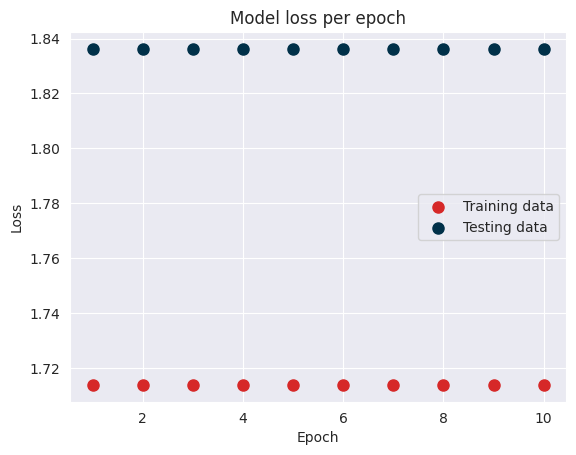

In [43]:
# Plot the average loss per epoch
ax1 = df_eval.plot(kind='scatter', x='epoch', y='train_loss', title='Model loss per epoch', label='Training data', color=my_palette[0], s=64)
ax2 = df_eval.plot(kind='scatter', x='epoch', y='test_loss', label='Testing data', color=my_palette[1], s=64, ax=ax1)

# Clean up x- and y-axes
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

# Save figure
plt.savefig(os.path.join(FIGURE_PATH,'model-eval-loss.pdf'), bbox_inches='tight');

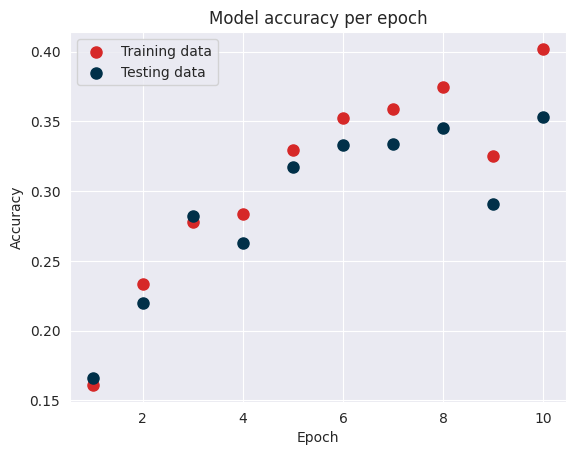

In [42]:
# Plot the accuracy per epoch
ax1 = df_eval.plot(kind='scatter', x='epoch', y='train_accuracy', title='Model accuracy per epoch', label='Training data', color=my_palette[0], s=64)
ax2 = df_eval.plot(kind='scatter', x='epoch', y='test_accuracy', label='Testing data', color=my_palette[1], s=64, ax=ax1)

# Clean up x- and y-axes
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

# Save figure
plt.savefig(os.path.join(FIGURE_PATH,'model-eval-accuracy.pdf'), bbox_inches='tight');